In [4]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict
import random

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

torch.set_printoptions(precision=3)

from SSD_model import get_SSD_model
from VOC_data import VOC_dataset
from draw_img_utils import *
from SSDloss import *

In [5]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

In [4]:
PATH = 'C:\\datasets\\pascal\\'
anno_path = f'{PATH}PASCAL_VOC\\pascal_train2007.json'
train_dataset = VOC_dataset(PATH, anno_path)
img_idx = 7

img, bbox, label = train_dataset[img_idx]

# img2, bbox2, label2 = train_dataset[img_idx + 1]
# img = torch.stack((img, img2))
# bbox = (bbox, bbox2)
# label = (label, label2)

In [42]:
model = get_SSD_model(1)

In [44]:
conf, loc = model(img.unsqueeze(dim=0))

In [45]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


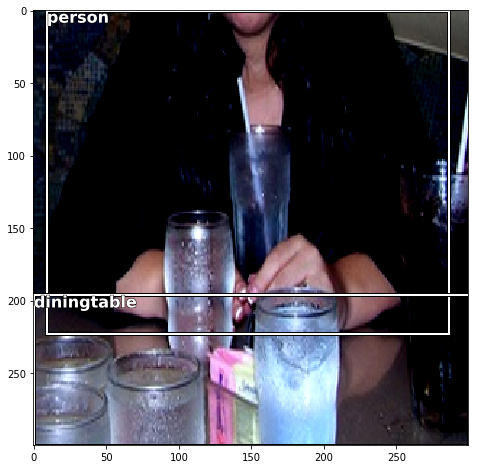

In [47]:
draw_im_with_data(cv2.cvtColor(np.array(img.permute(1, 2, 0)) / 255, cv2.COLOR_BGR2RGB), bbox, label, idx_category, 'xywh')

In [48]:
# 2 get the coordinate of each priorbox

# problem: about 350 size (width + height) is greater than 300, how to deal with them?

feature_map = [38, 19, 10, 5, 3, 1]
min_size = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88]
max_size = min_size[1:] + [1.05]
aspect_ratio = [[2], [2,3], [2,3], [2,3], [2], [2]]

prior_box = []
for k, f in enumerate(feature_map):
    for i, j in product(range(feature_map[k]), repeat=2):
        cx, cy = (i + 0.5) / f, (j + 0.5) / f
        h, w  = [], []
        h.append(min_size[k]); w.append(min_size[k])
        h.append((min_size[k] * max_size[k]) ** 0.5); w.append((min_size[k] * max_size[k]) ** 0.5)
        
        for ar in aspect_ratio[k]:
            h.append((min_size[k] / ar) ** 0.5); w.append((min_size[k] * ar) ** 0.5)
            h.append((min_size[k] * ar) ** 0.5); w.append((min_size[k] / ar) ** 0.5)
        
        for hi, wi in zip(h, w):
            prior_box.append((cx, cy, hi, wi))
#     print(len(prior_box))
prior_box = torch.tensor(prior_box)

In [49]:
# check the correctness of coordinate
# random position's coordinate, manually check if it's correct 
prior_box[38 * 38 * 4]

tensor([0.026, 0.026, 0.200, 0.200])

In [50]:
prior_box[38 * 38 * 4 - 38 * 4]

tensor([0.987, 0.013, 0.100, 0.100])

In [51]:
# 3 get iou of each image, shape: (number of objects, 8732)

# Adapated from https://github.com/amdegroot/ssd.pytorch

# Since every image contains different number of objects, the matrix for iou will be different
# We have to use a for loop to handle all the images in a batch

def get_iou(bbox, prior_box):
    '''
    id, int, selected id among the imgs_bbox
    imgs_bbox: List[List[cx, cy, w, h]]
    prior_box: tensor, (8732, 4)
    '''
#     gt = torch.FloatTensor(imgs_bbox[id])
    gt = torch.FloatTensor(bbox.copy())
#     gt = bbox.clone()
    
    
    # rescale
    gt /= 300
    
    # transform gt
    gt[:, 2:] = gt[:, :2] + gt[:, 2:]
    
    # transform prior_box
#     prior_box_ = torch.cat([prior_box[:, :2] - prior_box[:, 2:] / 2, prior_box[:, :2] + prior_box[:, 2:] / 2], dim=1)
    prior_box_ = torch.cat([(prior_box[:, 1] - prior_box[:, 2] / 2).unsqueeze(1), 
                            (prior_box[:, 0] - prior_box[:, 3] / 2).unsqueeze(1), 
                            (prior_box[:, 1] + prior_box[:, 2] / 2).unsqueeze(1), 
                            (prior_box[:, 0] + prior_box[:, 3] / 2).unsqueeze(1)], dim=1)
    
    print(prior_box_.shape)
    
    A = gt.size(0)
    B = prior_box_.size(0)
    
    max_xy = torch.min(gt[:, 2:].unsqueeze(1).expand(A, B, 2),
                       prior_box_[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(gt[:, :2].unsqueeze(1).expand(A, B, 2),
                       prior_box_[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    inter = inter[:, :, 0] * inter[:, :, 1]
    
    area_a = ((gt[:, 2]-gt[:, 0]) *
              (gt[:, 3]-gt[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((prior_box_[:, 2]-prior_box_[:, 0]) *
              (prior_box_[:, 3]-prior_box_[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    
    return inter / union

iou = get_iou(bbox, prior_box)

torch.Size([8732, 4])


torch.Size([8732, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Randomly select prior_box_id: 7007
 (y_center, x_center, w, h): tensor([0.553, 0.816, 0.272, 0.272])


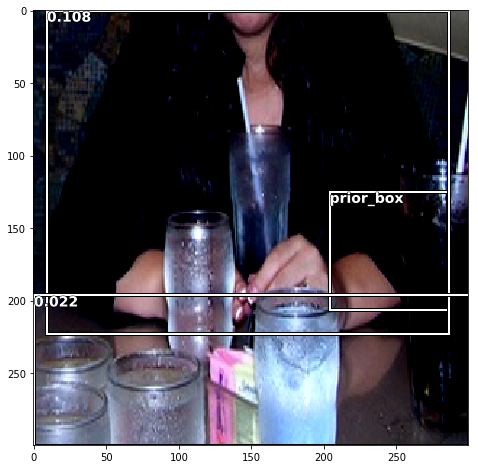

In [52]:
# 3.5 prove the calculate iou process is correct
def check_iou_random_pirorbox(prior_box, img, bbox, label):
    '''
    Description:
    Randomly pick a priorbox and check the iou of this priorbox
    
    Arguments:
    prior_box: torch.tensor (8732, 4), prior box
    img: (300, 300, 3) ndarray, image
    bbox: (k, 4) ndarray, k * (x, y, w, h) coordinates 
    label: (k, ) ndarray, k * 1 labels
    
    (k is the number of objects in the image)
    
    Return:
    None
    '''
    prior_box_id = random.randint(0, 8731)
    iou = get_iou(bbox, prior_box)
    original_bbox = torch.cat((reversed(prior_box[prior_box_id, :2] * 300) - prior_box[prior_box_id, 2:] * 300 / 2,
                          prior_box[prior_box_id, 2:] * 300))
    
    fig_, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(cv2.cvtColor(np.array(img.permute(1, 2, 0)) / 255, cv2.COLOR_BGR2RGB))
    
    draw_rect(ax, original_bbox)
    draw_text(ax, (reversed(prior_box[prior_box_id, :2] * 300) - prior_box[prior_box_id, 2:] * 300 / 2), txt='prior_box')
    
    for i, bbox_ in enumerate(bbox):
        y, x, width, height = bbox_
        draw_rect(ax, bbox_)
        draw_text(ax, [y, x], txt=round(float(iou[i, prior_box_id]), 3))
    
    print("Randomly select prior_box_id: {}\n (y_center, x_center, w, h): {}".format(prior_box_id, prior_box[prior_box_id]))

check_iou_random_pirorbox(prior_box, img, bbox, label)

In [54]:
# 4. get the best matche of each priorbox

best_each_prior_box = iou.argmax(0)
cls_target = torch.tensor(label)[best_each_prior_box]
bbox_target = torch.tensor(bbox)[best_each_prior_box]

# get the positive tags of the image
pos_mask = iou.max(0)[0] > 0.5

# get the best match of each object
best_each_object = iou.argmax(1)

for i, k in enumerate(best_each_object):
    cls_target[k] = imgs_class[img_idx][i]
    pos_mask[k] = 1
    bbox_target[k] = torch.FloatTensor(bbox[i])
    
cls_target[1 - pos_mask] = 0
cls_target[pos_mask] += 1

torch.Size([8732, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


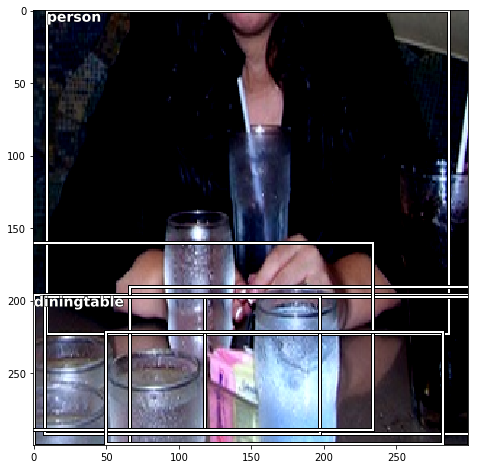

In [55]:
# 3.6 randomly select max(5 or 5%) of the valid(iou > 0.5) prior_box, check the iou
def check_iou_valid_priorbox(prior_box, img, bbox, label):
    iou = get_iou(bbox, prior_box)

    fig_, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(cv2.cvtColor(np.array(img.permute(1, 2, 0)) / 255, cv2.COLOR_BGR2RGB))

    for i, bbox_ in enumerate(bbox):
        y, x, width, height = bbox_
        draw_rect(ax, torch.tensor(bbox_))
        draw_text(ax, [y, x], txt=idx_category[np.array(label)[i]])

    selected_index = set()
    # print(min((5, int(0.05 * torch.sum(pos_mask)))))
    for _ in range(max(5, int(0.05 * torch.sum(pos_mask)))):
        idx = random.randint(0, torch.sum(pos_mask) - 1)
        if idx in selected_index:
            continue
        p = prior_box[pos_mask][idx]
        draw_rect(ax, torch.cat((reversed(p[:2] * 300) - p[2:] * 300 / 2,
                                 p[2:] * 300)))

check_iou_valid_priorbox(prior_box, img, bbox, label)

In [56]:
# 5. encode the bbox_target

variance = [0.1, 0.2]

bbox_target /= 300

# get the gt center x and y
cxcy = bbox_target[:, 0:2] + bbox_target[:, 2:4] / 2
cxcy = (cxcy - reversed(prior_box[:, 0:2])) / (prior_box[:, 2:4] * variance[0])

# get the gt weight and height
wh = torch.log(bbox_target[:, 2:4] / prior_box[:, 2:4])
wh /= variance[1]

bbox_target = torch.cat((cxcy, wh), dim=1)

In [59]:
conf, loc = conf.squeeze(0), loc.squeeze(0)

In [64]:
cls_target[pos_mask]

tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16,
        16, 16, 16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 16, 12, 12,
        12, 12, 12, 16, 16, 16, 16, 12, 12, 12, 16, 16, 16, 16, 16, 16, 16],
       dtype=torch.int32)

In [68]:
cls_target.long()

tensor([ 0,  0,  0,  ..., 16,  0, 16])

In [65]:
conf[pos_mask].shape

torch.Size([71, 21])

In [72]:
loc[pos_mask].shape

torch.Size([71, 4])

In [74]:
bbox_target[pos_mask].shape

torch.Size([71, 4])

In [69]:
# 6. hard negative mining

ratio = 3

num_pos = torch.sum(pos_mask)
num_neg = ratio * num_pos

conf_criterion = nn.CrossEntropyLoss(reduce=False)

loss_c_pos = conf_criterion(conf[pos_mask], cls_target.long()[pos_mask])
loss_c_pos = torch.sum(loss_c_pos)

D:\py3\anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [70]:
loss_c_pos

tensor(375.464, grad_fn=<SumBackward0>)